In [1]:
from config import BASE_PATH, TRACKS_PER_FILE, NUM_FILES
from config import Config
from series_processing import process_series
from file_io import check_and_load_or_process
import numpy as np
import matplotlib.pyplot as plt
    

In [2]:

LP_filename = r"\\tsclient\TESTFOLDER\20241119\long-good-noise"
lp_offset = 54
HP_filename = r"\\tsclient\TESTFOLDER\20241119\short-good-noise"
hp_offset = 13

traces_LP = check_and_load_or_process("", lp_offset, LP_filename, TRACKS_PER_FILE, NUM_FILES)

traces_HP = check_and_load_or_process("",
        hp_offset, HP_filename, TRACKS_PER_FILE, NUM_FILES
    )

results_hp = []
results_lp = []
for trace in traces_HP:
    conf = Config(**trace['args'])
    result = process_series(trace['series'], conf)
    results_hp.append(result)
    
for trace in traces_LP:
    conf = Config(**trace['args'])
    result = process_series(trace['series'], conf)
    results_lp.append(result)

# Average the HP PSDs
hp_PSDs = np.array([item["psd"][1:-1] for item in results_hp])
hp_avg_psd = np.mean(hp_PSDs, axis=0)

lp_PSDs = np.array([item["psd"][1:-1] for item in results_lp])
lp_avg_psd = np.mean(lp_PSDs, axis=0)


Processing data for 
Reading  \\tsclient\TESTFOLDER\20241119\long-good-noise 0
Reading  \\tsclient\TESTFOLDER\20241119\long-good-noise 1
Reading  \\tsclient\TESTFOLDER\20241119\long-good-noise 2
Reading  \\tsclient\TESTFOLDER\20241119\long-good-noise 3
Reading  \\tsclient\TESTFOLDER\20241119\long-good-noise 4
Reading  \\tsclient\TESTFOLDER\20241119\long-good-noise 5
Reading  \\tsclient\TESTFOLDER\20241119\long-good-noise 6
Reading  \\tsclient\TESTFOLDER\20241119\long-good-noise 7
Reading  \\tsclient\TESTFOLDER\20241119\long-good-noise 8
Reading  \\tsclient\TESTFOLDER\20241119\long-good-noise 9
Processing data for 
Reading  \\tsclient\TESTFOLDER\20241119\short-good-noise 0
Reading  \\tsclient\TESTFOLDER\20241119\short-good-noise 1
Reading  \\tsclient\TESTFOLDER\20241119\short-good-noise 2
Reading  \\tsclient\TESTFOLDER\20241119\short-good-noise 3
Reading  \\tsclient\TESTFOLDER\20241119\short-good-noise 4
Reading  \\tsclient\TESTFOLDER\20241119\short-good-noise 5
Reading  \\tsclient\TEST

Text(0, 0.5, 'Signal [V^2/Hz]')

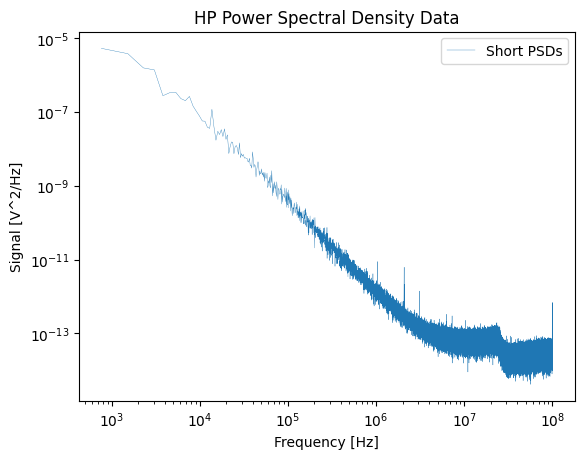

In [3]:
freq_hp = results_hp[0]["frequency"][1:-1]
plt.plot(freq_hp, hp_avg_psd, label="Short PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("HP Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")

Text(0, 0.5, 'Signal [V^2/Hz]')

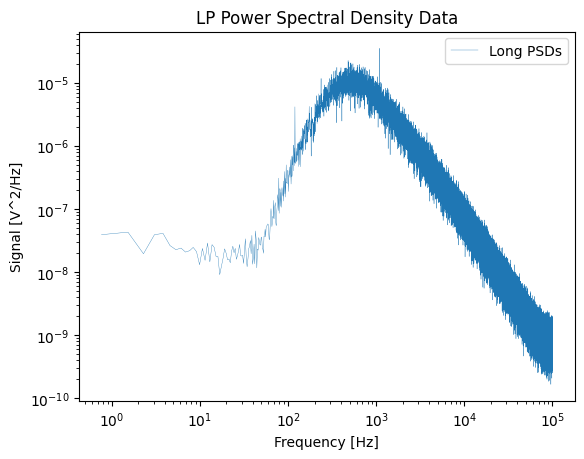

In [4]:
freq_lp = results_lp[0]["frequency"][1:-1]
plt.plot(freq_lp, lp_avg_psd, label="Long PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("LP Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")

Text(0, 0.5, 'Signal [V^2/Hz]')

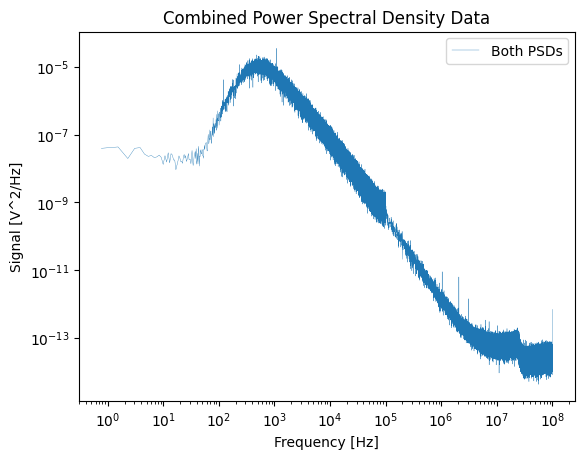

In [5]:
# Combine the psds together

freq_combined = np.concatenate((freq_lp, freq_hp))
psd_combined = np.concatenate((lp_avg_psd, hp_avg_psd))

# Sort the combined arrays by frequency
sorted_indices = np.argsort(freq_combined)
freq_combined = freq_combined[sorted_indices]
psd_combined = psd_combined[sorted_indices]

plt.plot(freq_combined, psd_combined, label="Both PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Combined Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")